# **Predict an equity price trend using LSTM**
To predict the price of a stock in Hong Kong based on the current Adjusted Close Price.
Using the Long Short Term Memory (LSTM) to predict the closing price of Tencent based on the past 50 days of stock price.

# **Predicting the Adjusted Closing Price of Tencent**
Using the Long Short Term Memory (LSTM) to predict the Adjusted Closing Price of a company Tencent (0700) based on the past 50 days of its Adjusted Closing Price. Using the period between 2005-01-03 to 2020-12-04 as training data.

In [2]:
!pip install yfinance

     |████████████████████████████████| 63 kB 859 kB/s 
     |████████████████████████████████| 6.4 MB 33.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [3]:
# Getting the quote
import math
from pandas_datareader import data as pdr
import yfinance as yfin
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")
yfin.pdr_override()


tencent = pdr.get_data_yahoo("0700.HK", start='2005-01-03',end='2020-12-04')
tencent

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-03,0.940,0.950,0.925,0.925,0.893928,42585000
2005-01-04,0.935,0.960,0.930,0.960,0.927752,82450000
2005-01-05,0.950,0.950,0.930,0.940,0.908424,48495000
2005-01-06,0.940,0.945,0.930,0.940,0.908424,41089000
2005-01-07,0.940,0.950,0.930,0.940,0.908424,37435000
...,...,...,...,...,...,...
2020-11-27,586.000,594.500,583.000,583.000,581.414917,11181079
2020-11-30,582.000,584.500,563.000,563.000,561.469299,32813194
2020-12-01,573.000,581.000,571.500,578.000,576.428528,22221870


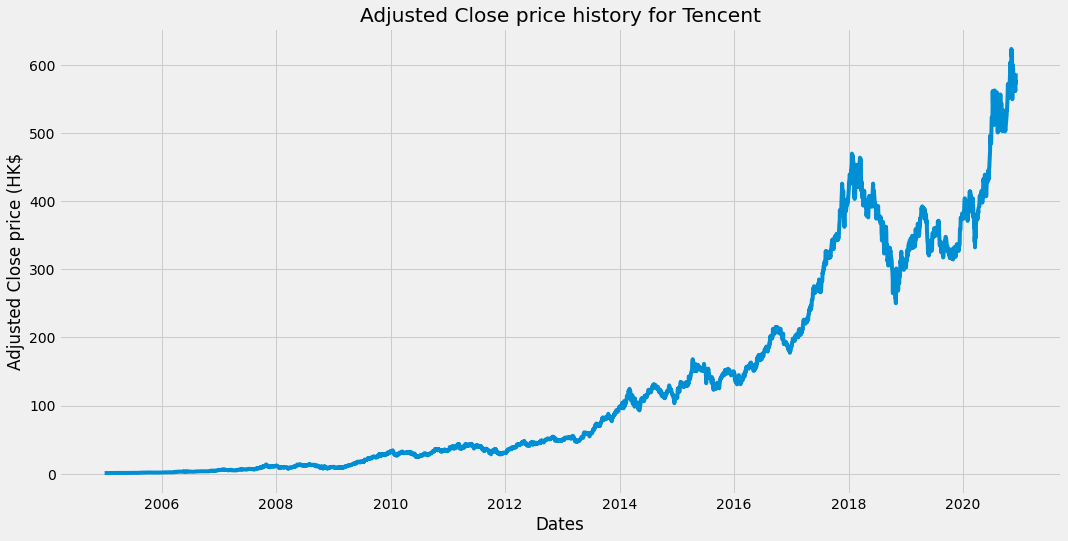

In [4]:
plt.figure(figsize=(16, 8))
plt.title("Adjusted Close price history for Tencent")
plt.plot(tencent["Adj Close"])
plt.xlabel("Dates")
plt.ylabel("Adjusted Close price (HK$")
plt.show()

# Data Preprocessing

In [5]:
# Create a new dataframe and converting it into a numpy array
adjclose=tencent.filter(['Adj Close'])
print(adjclose)

npdata = adjclose.values
print(f"\nThe shape of npdata is: {npdata.shape}")

             Adj Close
Date                  
2005-01-03    0.893928
2005-01-04    0.927752
2005-01-05    0.908424
2005-01-06    0.908424
2005-01-07    0.908424
...                ...
2020-11-27  581.414917
2020-11-30  561.469299
2020-12-01  576.428528
2020-12-02  572.439392
2020-12-03  587.398621

[3930 rows x 1 columns]

The shape of npdata is: (3930, 1)


In [6]:
training_data_len = math.ceil(len(npdata)*0.9)
training_data_len

3537

In [7]:
# Normalising the data in a numpy array of adjclose
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(npdata)
scaled_data

array([[9.31531118e-05],
       [1.47492451e-04],
       [1.16441414e-04],
       ...,
       [9.24699045e-01],
       [9.18290432e-01],
       [9.42322681e-01]])

In [8]:
# Creating scaled training data
train_data=scaled_data[0:training_data_len,:]

x_train = []
y_train = []

for i in range(50, len(train_data)):
  x_train.append(train_data[i-50:i,0])
  y_train.append(train_data[i, 0])

train_data

array([[9.31531118e-05],
       [1.47492451e-04],
       [1.16441414e-04],
       ...,
       [6.22280089e-01],
       [6.16544127e-01],
       [5.97105756e-01]])

In [9]:
x_train = np.array(x_train)
print(x_train)
print(f"\nThe shape of x_train is {x_train.shape}")

[[9.31531118e-05 1.47492451e-04 1.16441414e-04 ... 2.71696504e-04
  2.40645275e-04 2.25119996e-04]
 [1.47492451e-04 1.16441414e-04 1.16441414e-04 ... 2.40645275e-04
  2.25119996e-04 2.56170938e-04]
 [1.16441414e-04 1.16441414e-04 1.16441414e-04 ... 2.25119996e-04
  2.56170938e-04 2.87221783e-04]
 ...
 [5.30505181e-01 5.40065053e-01 5.35285117e-01 ... 6.10489587e-01
  6.21005436e-01 6.16862802e-01]
 [5.40065053e-01 5.35285117e-01 5.41977056e-01 ... 6.21005436e-01
  6.16862802e-01 6.22280089e-01]
 [5.35285117e-01 5.41977056e-01 5.45482339e-01 ... 6.16862802e-01
  6.22280089e-01 6.16544127e-01]]

The shape of x_train is (3487, 50)


In [10]:
y_train = np.array(y_train)
print(y_train)
print(f"\nThe shape of y_train is {y_train.shape}")

[2.56170938e-04 2.87221783e-04 3.80374608e-04 ... 6.22280089e-01
 6.16544127e-01 5.97105756e-01]

The shape of y_train is (3487,)


In [11]:
# Reshaping the x_train to be suitable for LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(3487, 50, 1)

In [12]:
# Creating test data
test_data = scaled_data[training_data_len-50:,:]
x_test = []
y_test = npdata[training_data_len:,:]

for i in range(50, len(test_data)):
  x_test.append(test_data[i-50:i,0])

test_data

array([[0.54197706],
       [0.54548234],
       [0.54675699],
       [0.54643832],
       [0.54516366],
       [0.54070245],
       [0.53369179],
       [0.53432919],
       [0.55121825],
       [0.57448063],
       [0.57543666],
       [0.56460208],
       [0.55153693],
       [0.56396478],
       [0.57384338],
       [0.56970069],
       [0.56842604],
       [0.57065672],
       [0.58627118],
       [0.58818314],
       [0.58818314],
       [0.57702994],
       [0.58021654],
       [0.5623715 ],
       [0.55854754],
       [0.56364616],
       [0.56269013],
       [0.57384338],
       [0.58021654],
       [0.58180992],
       [0.60092967],
       [0.59774301],
       [0.604435  ],
       [0.60985224],
       [0.61813745],
       [0.62228009],
       [0.626104  ],
       [0.61718148],
       [0.62578537],
       [0.62897198],
       [0.62259876],
       [0.62482939],
       [0.62482939],
       [0.60857753],
       [0.61048959],
       [0.62100544],
       [0.6168628 ],
       [0.622

In [13]:
x_test = np.array(x_test)
x_test.shape

(393, 50)

In [14]:
# Reshaping x_test according to LSTM
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(393, 50, 1)

# Building the Model


In [15]:
# Creating the model

model = Sequential()
model.add(LSTM(units=100,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=100,return_sequences=False))
model.add(Dense(units=50))
model.add(Dense(units=1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 50)                5050      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 126,301
Trainable params: 126,301
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Compiling the model

model.compile(optimizer="adam", loss="mean_squared_error")

In [17]:
# Training the model

model.fit(x_train, y_train, batch_size=5, epochs=20)

Epoch 1/20
698/698 [==============================] - 32s 32ms/step - loss: 6.5685e-04
Epoch 2/20
698/698 [==============================] - 20s 28ms/step - loss: 2.7323e-04
Epoch 3/20
698/698 [==============================] - 22s 31ms/step - loss: 1.4578e-04
Epoch 4/20
698/698 [==============================] - 19s 27ms/step - loss: 2.1441e-04
Epoch 5/20
698/698 [==============================] - 19s 27ms/step - loss: 1.0469e-04
Epoch 6/20
698/698 [==============================] - 19s 27ms/step - loss: 1.2519e-04
Epoch 7/20
698/698 [==============================] - 19s 27ms/step - loss: 1.0142e-04
Epoch 8/20
698/698 [==============================] - 19s 27ms/step - loss: 7.6252e-05
Epoch 9/20
698/698 [==============================] - 20s 28ms/step - loss: 9.9537e-05
Epoch 10/20
698/698 [==============================] - 19s 27ms/step - loss: 7.3875e-05
Epoch 11/20
698/698 [==============================] - 19s 27ms/step - loss: 6.7815e-05
Epoch 12/20
698/698 [====================

# Testing the Model

In [21]:
preds = model.predict(x_test)
preds = scaler.inverse_transform(preds) # inversing the previously done scaling to get actual value of adj close price instead of normalised value

rmse = np.sqrt(np.mean(((preds-y_test) ** 2)))

print(f"RMSE value is {rmse}")

RMSE value is 10.394750553026737


# Testing the Data

In [22]:
train = adjclose[:training_data_len]
valid = adjclose[training_data_len:]
valid["Predictions"] = preds

valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Adj Close,Predictions
Date,,
2019-05-07,377.670471,375.073151
2019-05-08,381.637604,382.292603
2019-05-09,372.513245,386.017517
2019-05-10,378.860626,375.697601
2019-05-14,367.554321,384.180115
...,...,...
2020-11-27,581.414917,590.918945
2020-11-30,561.469299,584.114136
2020-12-01,576.428528,561.342896


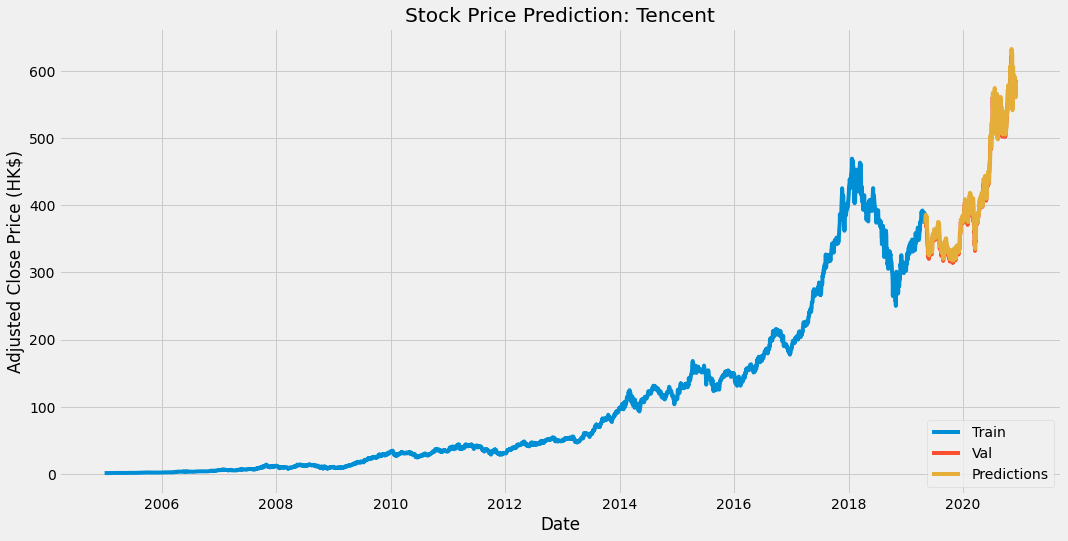

In [28]:
# Plotting the predicted data against the training data to visualize accuracy

plt.figure(figsize=(16, 8))
plt.title("Stock Price Prediction: Tencent")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price (HK$)")
plt.plot(train["Adj Close"])
plt.plot(valid[["Adj Close", "Predictions"]])
plt.legend(['Train','Val','Predictions'],loc='lower right')
plt.show()